A much shorter/ipynb version of train.py for demo tranning shakespeare_char

This file a created from train.py with custom shakespeare-char and simpler/smaller value config for quick demo integration in jupyter lab

In [1]:
import os
import time
import math
import pickle
from contextlib import nullcontext

import numpy as np
import torch
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group

from model import GPTConfig, GPT

from animator import Animator

In [2]:
# -----------------------------------------------------------------------------
# default config values designed to train a gpt2 (124M) on OpenWebText
# I/O
out_dir = 'out'
eval_interval = 2000
log_interval = 1
eval_iters = 200
eval_only = False # if True, script exits right after the first eval
always_save_checkpoint = True # if True, always save a checkpoint after each eval
init_from = 'scratch' # 'scratch' or 'resume' or 'gpt2*'
# wandb logging
wandb_log = False # disabled by default
wandb_project = 'owt'
wandb_run_name = 'gpt2' # 'run' + str(time.time())
# data
dataset = 'openwebtext'
gradient_accumulation_steps = 5 * 8 # used to simulate larger batch sizes
batch_size = 12 # if gradient_accumulation_steps > 1, this is the micro-batch size
block_size = 1024
# model
n_layer = 12
n_head = 12
n_embd = 768
dropout = 0.0 # for pretraining 0 is good, for finetuning try 0.1+
bias = False # do we use bias inside LayerNorm and Linear layers?
# adamw optimizer
learning_rate = 6e-4 # max learning rate
max_iters = 600000 # total number of training iterations
weight_decay = 1e-1
beta1 = 0.9
beta2 = 0.95
grad_clip = 1.0 # clip gradients at this value, or disable if == 0.0
# learning rate decay settings
decay_lr = True # whether to decay the learning rate
warmup_iters = 2000 # how many steps to warm up for
lr_decay_iters = 600000 # should be ~= max_iters per Chinchilla
min_lr = 6e-5 # minimum learning rate, should be ~= learning_rate/10 per Chinchilla
# DDP settings
backend = 'nccl' # 'nccl', 'gloo', etc.
# system
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1' etc., or try 'mps' on macbooks
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
compile = True # use PyTorch 2.0 to compile the model to be faster

In [16]:
# -----------------------------------------------------------------------------
config_keys = [k for k,v in globals().items() if not k.startswith('_') and isinstance(v, (int, float, bool, str))]
# -----------------------------------------------------------------------------

# train a miniature character-level shakespeare model
# good for debugging and playing on macbooks and such

out_dir = 'out-shakespeare-char'
eval_interval = 250 # keep frequent because we'll overfit
eval_iters = 200
log_interval = 10 # don't print too too often

# we expect to overfit on this small dataset, so only save when val improves
always_save_checkpoint = False

wandb_log = False # override via command line if you like
wandb_project = 'shakespeare-char'
wandb_run_name = 'mini-gpt'

dataset = 'shakespeare_char'
gradient_accumulation_steps = 1
batch_size = 64
block_size = 256 # context of up to 256 previous characters

# baby GPT model :)
n_layer = 6
n_head = 6
n_embd = 384
dropout = 0.2

learning_rate = 1e-3 # with baby networks can afford to go a bit higher
max_iters = 5000
lr_decay_iters = 5000 # make equal to max_iters usually
min_lr = 1e-4 # learning_rate / 10 usually
beta2 = 0.99 # make a bit bigger because number of tokens per iter is small

warmup_iters = 100 # not super necessary potentially

# -----------------------------------------------------------------------------
# simpler/smaller value config for demo jupyter lab integration
device = 'cpu'  # run on cpu only
compile = False # do not torch compile the model
eval_iters = 20
log_interval = 1000
block_size = 64
batch_size = 12
n_layer = 4
n_head = 4
n_embd = 128
max_iters = 1000 #2000
lr_decay_iters = 1000 #2000
dropout = 0.0

# -----------------------------------------------------------------------------
config = {k: globals()[k] for k in config_keys} # will be useful for logging
# -----------------------------------------------------------------------------

config

{'out_dir': 'out-shakespeare-char',
 'eval_interval': 250,
 'log_interval': 1000,
 'eval_iters': 20,
 'eval_only': False,
 'always_save_checkpoint': False,
 'init_from': 'scratch',
 'wandb_log': False,
 'wandb_project': 'shakespeare-char',
 'wandb_run_name': 'mini-gpt',
 'dataset': 'shakespeare_char',
 'gradient_accumulation_steps': 1,
 'batch_size': 12,
 'block_size': 64,
 'n_layer': 4,
 'n_head': 4,
 'n_embd': 128,
 'dropout': 0.0,
 'bias': False,
 'learning_rate': 0.001,
 'max_iters': 1000,
 'weight_decay': 0.1,
 'beta1': 0.9,
 'beta2': 0.99,
 'grad_clip': 1.0,
 'decay_lr': True,
 'warmup_iters': 100,
 'lr_decay_iters': 1000,
 'min_lr': 0.0001,
 'backend': 'nccl',
 'device': 'cpu',
 'dtype': 'float16',
 'compile': False,
 'ddp': False,
 'master_process': True,
 'seed_offset': 0,
 'ddp_world_size': 1,
 'tokens_per_iter': 768,
 'device_type': 'cpu',
 'data_dir': 'data/shakespeare_char',
 'iter_num': 1001,
 'meta_path': 'data/shakespeare_char/meta.pkl',
 'meta_vocab_size': 65,
 't0': 1

In [4]:
# various inits, derived attributes, I/O setup
ddp = False # is this a ddp run?
if ddp:
    pass
else:
    # if not ddp, we are running on a single gpu, and one process
    master_process = True
    seed_offset = 0
    ddp_world_size = 1
tokens_per_iter = gradient_accumulation_steps * ddp_world_size * batch_size * block_size
print(f"tokens per iteration will be: {tokens_per_iter:,}")

tokens per iteration will be: 768


In [5]:
if master_process:
    os.makedirs(out_dir, exist_ok=True)
torch.manual_seed(1337 + seed_offset)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

In [6]:
# poor man's data loader
data_dir = os.path.join('data', dataset)
train_data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r')
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y

In [7]:
# init these up here, can override if init_from='resume' (i.e. from a checkpoint)
iter_num = 0
best_val_loss = 1e9

In [8]:
# attempt to derive vocab_size from the dataset
meta_path = os.path.join(data_dir, 'meta.pkl')
meta_vocab_size = None
if os.path.exists(meta_path):
    with open(meta_path, 'rb') as f:
        meta = pickle.load(f)
    meta_vocab_size = meta['vocab_size']
    print(f"found vocab_size = {meta_vocab_size} (inside {meta_path})")

found vocab_size = 65 (inside data/shakespeare_char/meta.pkl)


In [9]:
# model init
model_args = dict(n_layer=n_layer, n_head=n_head, n_embd=n_embd, block_size=block_size,
                  bias=bias, vocab_size=None, dropout=dropout) # start with model_args from command line

In [10]:
if init_from == 'scratch':
    # init a new model from scratch
    print("Initializing a new model from scratch")
    # determine the vocab size we'll use for from-scratch training
    if meta_vocab_size is None:
        print("defaulting to vocab_size of GPT-2 to 50304 (50257 rounded up for efficiency)")
    model_args['vocab_size'] = meta_vocab_size if meta_vocab_size is not None else 50304
    gptconf = GPTConfig(**model_args)
    model = GPT(gptconf)
elif init_from == 'resume':
    pass
elif init_from.startswith('gpt2'):
    pass
# crop down the model block size if desired, using model surgery
if block_size < model.config.block_size:
    model.crop_block_size(block_size)
    model_args['block_size'] = block_size # so that the checkpoint will have the right value
model.to(device)


Initializing a new model from scratch
number of parameters: 0.80M


GPT(
  (transformer): ModuleDict(
    (wte): Embedding(65, 128)
    (wpe): Embedding(64, 128)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-3): 4 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=128, out_features=384, bias=False)
          (c_proj): Linear(in_features=128, out_features=128, bias=False)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=128, out_features=512, bias=False)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=512, out_features=128, bias=False)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=128, out_features=65, bias=False)
)

In [11]:
# initialize a GradScaler. If enabled=False scaler is a no-op
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

# optimizer
optimizer = model.configure_optimizers(weight_decay, learning_rate, (beta1, beta2), device_type)
if init_from == 'resume':
    pass
checkpoint = None # free up memory

# compile the model
if compile:
    pass

# wrap model into DDP container
if ddp:
    pass

num decayed parameter tensors: 18, with 802,944 parameters
num non-decayed parameter tensors: 9, with 1,152 parameters
using fused AdamW: False


/root/envs/myenv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


In [12]:
# helps estimate an arbitrarily accurate loss over either split using many batches
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            with ctx:
                logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [13]:
# learning rate decay scheduler (cosine with warmup)
def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    # 2) if it > lr_decay_iters, return min learning rate
    if it > lr_decay_iters:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)

In [14]:
# logging
if wandb_log and master_process:
    import wandb
    wandb.init(project=wandb_project, name=wandb_run_name, config=config)

step 0: train loss 4.1676, val loss 4.1649
iter 0: loss 4.1828, time 630.63ms, mfu -100.00%
iter 50: loss 2.9463, time 87.22ms, mfu 0.01%
iter 100: loss 2.6648, time 53.48ms, mfu 0.02%
iter 150: loss 2.5356, time 131.79ms, mfu 0.01%
iter 200: loss 2.5008, time 53.28ms, mfu 0.02%
step 250: train loss 2.4278, val loss 2.4416
saving checkpoint to out-shakespeare-char
iter 250: loss 2.4932, time 695.37ms, mfu 0.01%
iter 300: loss 2.3356, time 54.48ms, mfu 0.02%
iter 350: loss 2.3380, time 134.71ms, mfu 0.01%
iter 400: loss 2.3308, time 100.50ms, mfu 0.01%
iter 450: loss 2.3342, time 89.25ms, mfu 0.01%
step 500: train loss 2.2828, val loss 2.3266
saving checkpoint to out-shakespeare-char
iter 500: loss 2.3863, time 607.02ms, mfu 0.01%
iter 550: loss 2.2035, time 52.64ms, mfu 0.01%
iter 600: loss 2.1725, time 44.99ms, mfu 0.02%
iter 650: loss 2.1388, time 52.97ms, mfu 0.02%
iter 700: loss 2.1192, time 47.91ms, mfu 0.02%
step 750: train loss 2.1431, val loss 2.1873
saving checkpoint to out-sh

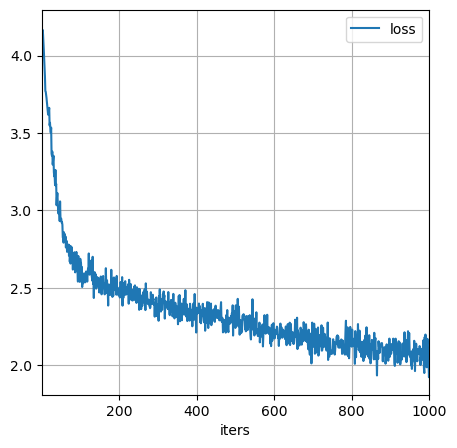

In [15]:
# set iter_num to 0 for rerun this cell when developing
if init_from == 'scratch':
  iter_num = 0
    
# training loop
X, Y = get_batch('train') # fetch the very first batch
t0 = time.time()
local_iter_num = 0 # number of iterations in the lifetime of this process
raw_model = model.module if ddp else model # unwrap DDP container if needed
running_mfu = -1.0

animator = Animator(xlabel='iters', xlim=[1, max_iters], legend=['loss'], figsize=(5, 5))

while True:

    # determine and set the learning rate for this iteration
    lr = get_lr(iter_num) if decay_lr else learning_rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    # evaluate the loss on train/val sets and write checkpoints
    if iter_num % eval_interval == 0 and master_process:
        losses = estimate_loss()
        print(f"step {iter_num}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        if wandb_log:
            wandb.log({
                "iter": iter_num,
                "train/loss": losses['train'],
                "val/loss": losses['val'],
                "lr": lr,
                "mfu": running_mfu*100, # convert to percentage
            })
        if losses['val'] < best_val_loss or always_save_checkpoint:
            best_val_loss = losses['val']
            if iter_num > 0:
                checkpoint = {
                    'model': raw_model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'model_args': model_args,
                    'iter_num': iter_num,
                    'best_val_loss': best_val_loss,
                    'config': config,
                }
                print(f"saving checkpoint to {out_dir}")
                torch.save(checkpoint, os.path.join(out_dir, 'ckpt.pt'))
    if iter_num == 0 and eval_only:
        break

    # forward backward update, with optional gradient accumulation to simulate larger batch size
    # and using the GradScaler if data type is float16
    for micro_step in range(gradient_accumulation_steps):
        if ddp:
            pass
        with ctx:
            logits, loss = model(X, Y)
            loss = loss / gradient_accumulation_steps # scale the loss to account for gradient accumulation
        # immediately async prefetch next batch while model is doing the forward pass on the GPU
        X, Y = get_batch('train')
        # backward pass, with gradient scaling if training in fp16
        scaler.scale(loss).backward()
    # clip the gradient
    if grad_clip != 0.0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    # step the optimizer and scaler if training in fp16
    scaler.step(optimizer)
    scaler.update()
    # flush the gradients as soon as we can, no need for this memory anymore
    optimizer.zero_grad(set_to_none=True)

    # timing and logging
    t1 = time.time()
    dt = t1 - t0
    t0 = t1
    if iter_num % log_interval == 0 and master_process:
        # get loss as float. note: this is a CPU-GPU sync point
        # scale up to undo the division above, approximating the true total loss (exact would have been a sum)
        lossf = loss.item() * gradient_accumulation_steps
        if local_iter_num >= 5: # let the training loop settle a bit
            mfu = raw_model.estimate_mfu(batch_size * gradient_accumulation_steps, dt)
            running_mfu = mfu if running_mfu == -1.0 else 0.9*running_mfu + 0.1*mfu
        print(f"iter {iter_num}: loss {lossf:.4f}, time {dt*1000:.2f}ms, mfu {running_mfu*100:.2f}%")
    
    if master_process:
        lossf = loss.item() * gradient_accumulation_steps
        animator.add(iter_num + 1, (lossf))
    
    iter_num += 1
    local_iter_num += 1

    # termination conditions
    if iter_num > max_iters:
        break

if ddp:
    pass
